# Regression Models Template

This notebook demonstrates linear, logistic, and ordinal regression using the waste charging policy dataset.

## Libraries
We will use:
- pandas for data handling
- numpy for numerical operations
- scikit-learn for linear and logistic regression
- statsmodels for ordinal regression

In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
from statsmodels.miscmodels.ordinal_model import OrderedModel
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
# Load the dataset
df = pd.read_csv("D:\\Incoming\\202526_S1\\GCAP3226\\GCAP3226_week3.csv")

# Display the first few rows to verify
df.head()

,ID,support_info,support_after_info,fairness,government_consideration,policy_helpfulness_original,policy_helpfulness,waste_severity,recycling_effort,food_waste_behavior,...,recycle_frequency,household_size,Q1_score,Q2_score,Q3_score,total_score,height,Distance to Nearest Recycling Facility,error,Distance_artificial
0,1,1,1,1,1,1,1,3,1,never_seen,...,1,0,0,1,0,1,1.72,400,-10.263397,259.826667
1,2,5,5,5,5,5,4,2,2,never_seen,...,2,1,0,1,1,2,1.85,300,90.062855,260.040000
2,3,3,5,5,4,2,2,3,1,seen_not_used,...,1,3,0,1,0,1,1.72,400,108.336080,338.893333
3,4,1,2,2,1,2,2,3,2,never_seen,...,2,0,0,1,1,2,1.67,300,-11.113667,192.593333
4,5,1,3,4,3,1,1,3,2,seen_not_used,...,2,2,0,1,1,2,1.84,300,49.418514,232.946667


In [4]:
# Recode age from binary columns to a single 'age' column with midpoints
age_columns = ['AgeRange_18-24', 'AgeRange_25-34', 'AgeRange_35-44', 'AgeRange_45-54', 'AgeRange_55-64', 'AgeRange_65+']
midpoints = [20, 30, 40, 50, 60, 70]

# Create 'age' column by finding the midpoint where the binary is 1
df['age'] = np.nan
for col, midpoint in zip(age_columns, midpoints):
    df.loc[df[col] == 1, 'age'] = midpoint

# Handle any missing ages if necessary (e.g., drop or impute)
df = df.dropna(subset=['age'])  # Example: drop rows with missing age

# Verify the new 'age' column
df['age'].value_counts()

age
40.0    26
30.0    23
50.0    22
20.0    19
60.0     6
70.0     1
Name: count, dtype: int64

## Part 1: Linear Regression

We treat 'support_info' as a continuous variable for linear regression purposes.

### Simple Linear Regression 1: support_info vs fairness

Model Summary:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4950      0.247      2.007      0.048       0.005       0.985
fairness       0.7936      0.078     10.184      0.000       0.639       0.948

R-squared: 0.5219


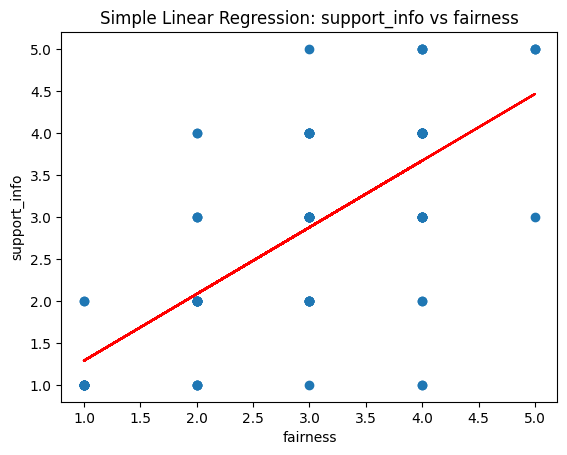

In [26]:
# Prepare data
X1 = df[['fairness']].dropna()
y = df.loc[X1.index, 'support_info']

# Fit model using sklearn for predictions
lin_reg1 = LinearRegression()
lin_reg1.fit(X1, y)

# Fit model using statsmodels for statistical tests
X1_sm = sm.add_constant(X1)  # Add constant term for intercept
model = sm.OLS(y, X1_sm)
results = model.fit()

# Predictions for plotting
y_pred1 = lin_reg1.predict(X1)

print("Model Summary:")
print(results.summary().tables[1])  # Print coefficient statistics
print(f"\nR-squared: {results.rsquared:.4f}")

# Plot
plt.scatter(X1, y)
plt.plot(X1, y_pred1, color='red')
plt.xlabel('fairness')
plt.ylabel('support_info')
plt.title('Simple Linear Regression: support_info vs fairness')
plt.show()

#### Interpreting Simple Linear Regression Results

The output above shows several key statistics:

1. **Coefficient Statistics Table:**
   - `coef`: The estimated coefficient value
   - `P>|t|`: p-value     

   P-value is the probability of obtaining the sample results (e.g., estimated coefficient values), or an even more extreme result, if the null hypothesis (that the coefficient equals zero) is true. If p-value is very small, this means that observing our sample result would be very unlikely under the null hypothesis (coefficient = 0). Given that we have observed such an unusual result, we have evidence to reject the null hypothesis and conclude that the coefficient is significantly different from zero.
   - `[0.025 0.975]`: 95% confidence interval

2. **How to interpret:**
   - If p-value < 0.05, a commonly used threshold which is called the significance level, the coefficient is significantly different from 0
   - Coefficient shows the average change in support_info for a one-unit increase in fairness
   - R-squared shows the proportion of variance explained by the model (0 to 1, higher is better). It measures model’s explanatory power.

3. **Plot interpretation:**
   - Scatter points show actual data
   - Red line shows the estimated relationship between variables
   - The closer points are to the line, the better the model fit

#### Interpreting Coefficients Estimate with Likert Scale Response Variable

When interpreting regression results with a Likert scale (1-5) response variable:

1. **Constant ($\hat \beta_0$) = 0.4950 (p = 0.048)**
   - This represents the predicted baseline support level (when fairness = 0)
   - While statistically significant (p < 0.05), the actual value has limited practical interpretation since fairness cannot be 0 on a 1-5 scale

2. **Fairness coefficient ($\hat \beta_1$) = 0.7936 (p < 0.001)**
   - For each one-unit increase in perceived fairness on the 1-5 scale, support is expected to increase by 0.7936 points
   - This is a strong positive relationship (close to 1 point increase for each point increase in fairness)
   - Highly significant (p < 0.001)

3. **Practical Example:**
   - If someone rates fairness as 3 ("neutral"):
     * Predicted support = 0.4950 + (0.7936 × 3) = 2.88
   - If they rate fairness as 4 ("fair"):
     * Predicted support = 0.4950 + (0.7936 × 4) = 3.67
   - This shows how higher fairness ratings associate with meaningfully higher support levels

4. **R-squared** indicates how much of the variation in support levels can be explained by perceived fairness alone.

### Simple Linear Regression 2: support_info vs Distance_artificial

Model Summary:
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.1969      0.404      5.432      0.000       1.394       3.000
Distance_artificial     0.0034      0.002      1.663      0.100      -0.001       0.007

R-squared: 0.0283


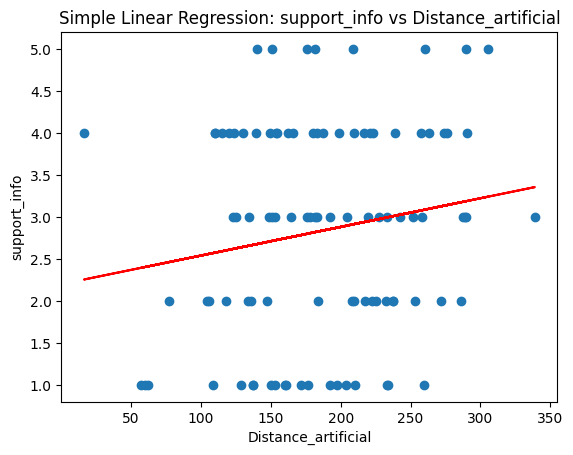

In [27]:
# Prepare data
X2 = df[['Distance_artificial']].dropna()
y = df.loc[X2.index, 'support_info']

# Fit model using sklearn for predictions
lin_reg2 = LinearRegression()
lin_reg2.fit(X2, y)

# Fit model using statsmodels for statistical tests
X2_sm = sm.add_constant(X2)  # Add constant term for intercept
model = sm.OLS(y, X2_sm)
results = model.fit()

# Predictions for plotting
y_pred2 = lin_reg2.predict(X2)

print("Model Summary:")
print(results.summary().tables[1])  # Print coefficient statistics
print(f"\nR-squared: {results.rsquared:.4f}")

# Plot
plt.scatter(X2, y)
plt.plot(X2, y_pred2, color='red')
plt.xlabel('Distance_artificial')
plt.ylabel('support_info')
plt.title('Simple Linear Regression: support_info vs Distance_artificial')
plt.show()

**Distance coefficient ($\hat \beta_1$) = 0.0034 (p = 0.1 > 0.05)**
   - There's no significant association between the distance to the recycle facilities to the level of support
   - Distance to the recycle facilities can only explain a very limited proportion of variance in the level of support


### Multiple Linear Regression: support_info vs fairness, government_consideration, policy_helpfulness, waste_severity, age

In [ ]:
# Prepare data
features = ['fairness', 'government_consideration', 'policy_helpfulness', 'waste_severity', 'age']
X_multi = df[features].dropna()
y_multi = df.loc[X_multi.index, 'support_info']

# Fit model using sklearn for predictions
lin_reg_multi = LinearRegression()
lin_reg_multi.fit(X_multi, y_multi)

# Fit model using statsmodels for statistical tests
X_multi_sm = sm.add_constant(X_multi)  # Add constant term for intercept
model = sm.OLS(y_multi, X_multi_sm)
results = model.fit()

print("Model Summary:")
print(results.summary().tables[1])  # Print coefficient statistics
print(f"\nR-squared: {results.rsquared:.4f}")

# Model significance
print("\nModel Diagnostics:")
print(f"F-statistic: {results.fvalue:.2f}")
print(f"Prob (F-statistic): {results.f_pvalue:.4f}")  # Overall model significance

Model Summary:
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.2093      0.476      0.440      0.661      -0.735       1.154
fairness                     0.4061      0.104      3.917      0.000       0.200       0.612
government_consideration     0.4286      0.118      3.646      0.000       0.195       0.662
policy_helpfulness           0.1867      0.111      1.686      0.095      -0.033       0.407
waste_severity               0.1334      0.139      0.958      0.341      -0.143       0.410
age                         -0.0122      0.007     -1.838      0.069      -0.025       0.001

R-squared: 0.6517
MSE: 0.56

Model Diagnostics:
F-statistic: 34.05
Prob (F-statistic): 0.0000


#### Interpreting Multiple Linear Regression Results

The output shows several important statistics:

1. **Coefficient Statistics Table:**
   - Each row represents one predictor variable
   - Interpretation is similar to simple regression, but now each coefficient represents the estimated effect while holding other variables constant
   - P>|t| < 0.05 indicates statistical significance

2. **Model Quality Metrics:**
   - R-squared: Proportion of variance explained by all predictors together (0 to 1, higher is better)
   - F-statistic and its p-value: Tests if the model as a whole is significant
     - If Prob (F-statistic) < 0.05, the model is statistically significant

3. **Coefficients:**
   - Positive coefficients indicate positive relationships
   - Negative coefficients indicate negative relationships
   - Compare standardized coefficients to assess relative importance, the larger absolute values, the stronger the effects

## Part 2: Logistic Regression

Recode 'support_info' to binary 'Support_binary' (1/2 -> 0; 4/5 -> 1; exclude 3)

In [14]:
# Recode support_info to Support_binary
df['Support_binary'] = np.nan
df.loc[df['support_info'].isin([1, 2]), 'Support_binary'] = 0
df.loc[df['support_info'].isin([4, 5]), 'Support_binary'] = 1

# Drop rows where Support_binary is NaN (i.e., original 3)
df_log = df.dropna(subset=['Support_binary'])

### Logistic Regression 1: Support_binary vs fairness

In [19]:
# Prepare data
X_log1 = df_log[['fairness']].dropna()
y_log = df_log.loc[X_log1.index, 'Support_binary']

# Fit model using sklearn for predictions
log_reg1 = LogisticRegression()
log_reg1.fit(X_log1, y_log)

# Fit model using statsmodels for statistical tests
X_log1_sm = sm.add_constant(X_log1)  # Add constant term for intercept
model = sm.Logit(y_log, X_log1_sm)
results = model.fit(method='newton')

# Predictions and metrics
y_pred_log1 = log_reg1.predict(X_log1)
acc1 = accuracy_score(y_log, y_pred_log1)
conf1 = confusion_matrix(y_log, y_pred_log1)

print("Model Summary:")
print(results.summary().tables[1])  # Print coefficient statistics
print(f"\nAccuracy: {acc1:.2f}")
print("\nConfusion Matrix:")
print(conf1)

# Additional model diagnostics
print("\nModel Diagnostics:")
print(f"Log-Likelihood: {results.llf:.2f}")
print(f"Pseudo R-squared: {results.prsquared:.4f}")
print(f"LLR p-value: {results.llr_pvalue:.4f}")  # Overall model significance

Optimization terminated successfully.
         Current function value: 0.377056
         Iterations 7
Model Summary:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.8165      1.319     -4.411      0.000      -8.401      -3.232
fairness       1.9254      0.411      4.689      0.000       1.121       2.730

Accuracy: 0.81

Confusion Matrix:
[[35  4]
 [10 25]]

Model Diagnostics:
Log-Likelihood: -27.90
Pseudo R-squared: 0.4549
LLR p-value: 0.0000


#### Interpreting Logistic Regression Results

The output includes several important measures:

1. **Coefficient Statistics Table:**
   - `coef`: Log odds ratio
   - `std err`: Standard error of the estimate
   - `z`: z-statistic (for testing significance)
   - `P>|z|`: p-value (statistical significance)
   - `[0.025 0.975]`: 95% confidence interval

2. **Model Quality Metrics:**
   - Pseudo R-squared: Measure of model fit (higher is better)
   - Log-Likelihood: Used for model comparison (higher is better)
   - LLR p-value: Tests if model is better than null model
   - Accuracy: Proportion of correct predictions
   - Confusion Matrix: Shows true vs predicted classifications
     - Row 1: True Negatives (0,0), False Positives (0,1)
     - Row 2: False Negatives (1,0), True Positives (1,1)

3. **Interpreting Coefficients:**
   - exp(coef) gives odds ratio
   - Positive coefficients increase probability of support
   - Negative coefficients decrease probability of support

### Logistic Regression 2: Support_binary vs fairness + government_consideration, policy_helpfulness, waste_severity, age

In [22]:
# Prepare data
features_log = ['fairness', 'government_consideration', 'policy_helpfulness', 'waste_severity', 'age']
X_log2 = df_log[features_log].dropna()
y_log2 = df_log.loc[X_log2.index, 'Support_binary']

# Fit model using sklearn for predictions
log_reg2 = LogisticRegression()
log_reg2.fit(X_log2, y_log2)

# Fit model using statsmodels for statistical tests
X_log2_sm = sm.add_constant(X_log2)  # Add constant term for intercept
model = sm.Logit(y_log2, X_log2_sm)
results = model.fit(method='newton')

# Predictions and metrics
y_pred_log2 = log_reg2.predict(X_log2)
acc2 = accuracy_score(y_log2, y_pred_log2)
conf2 = confusion_matrix(y_log2, y_pred_log2)

print("Model Summary:")
print(results.summary().tables[1])  # Print coefficient statistics
print(f"\nAccuracy: {acc2:.2f}")
print("\nConfusion Matrix:")
print(conf2)

# Additional model diagnostics
print("\nModel Diagnostics:")
print(f"Log-Likelihood: {results.llf:.2f}")
print(f"Pseudo R-squared: {results.prsquared:.4f}")
print(f"LLR p-value: {results.llr_pvalue:.4f}")  # Overall model significance

Optimization terminated successfully.
         Current function value: 0.145761
         Iterations 11
Model Summary:
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      -22.1798      9.024     -2.458      0.014     -39.866      -4.494
fairness                     4.1282      1.748      2.362      0.018       0.702       7.554
government_consideration     4.9296      2.080      2.370      0.018       0.853       9.007
policy_helpfulness           1.6849      0.920      1.831      0.067      -0.119       3.488
waste_severity               0.0153      1.175      0.013      0.990      -2.288       2.319
age                         -0.2236      0.100     -2.229      0.026      -0.420      -0.027

Accuracy: 0.93

Confusion Matrix:
[[35  4]
 [ 1 34]]

Model Diagnostics:
Log-Likelihood: -10.79
Pseudo R-squared: 0.7893
LLR p-value: 0.0

## Part 3: Ordinal Regression

Recode 'support_info' to ordinal 'Support_ordinal' (1/2 -> 0; 3 -> 1; 4/5 -> 2)

Using statsmodels OrderedModel for proper ordinal regression.

In [23]:
# Recode support_info to Support_ordinal
df['Support_ordinal'] = np.nan
df.loc[df['support_info'].isin([1, 2]), 'Support_ordinal'] = 0
df.loc[df['support_info'] == 3, 'Support_ordinal'] = 1
df.loc[df['support_info'].isin([4, 5]), 'Support_ordinal'] = 2

# Drop rows where Support_ordinal is NaN (if any)
df_ord = df.dropna(subset=['Support_ordinal'])

### Ordinal Regression 1: Support_ordinal vs fairness

In [24]:
# Prepare data
X_ord1 = df_ord[['fairness']]
y_ord = df_ord['Support_ordinal']

# Fit model
ord_reg1 = OrderedModel(y_ord, X_ord1, distr='logit')
result1 = ord_reg1.fit(method='bfgs')

print(result1.summary())

Optimization terminated successfully.
         Current function value: 0.792489
         Iterations: 13
         Function evaluations: 16
         Gradient evaluations: 16
                             OrderedModel Results                             
Dep. Variable:        Support_ordinal   Log-Likelihood:                -76.871
Model:                   OrderedModel   AIC:                             159.7
Method:            Maximum Likelihood   BIC:                             167.5
Date:                Thu, 11 Sep 2025                                         
Time:                        16:32:56                                         
No. Observations:                  97                                         
Df Residuals:                      94                                         
Df Model:                           1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

#### Interpreting Ordinal Regression Results

The output includes several components:

1. **Model Summary Statistics:**
   - Log-Likelihood
   - LL-null: Log-likelihood of null model
   - LLR p-value: Test of model significance
   - AIC/BIC: Model comparison metrics (lower is better)

2. **Coefficient Table:**
   - Similar to logistic regression, but interprets differently
   - Positive coefficients indicate higher probability of being in higher categories
   - Negative coefficients indicate higher probability of being in lower categories
   - P>|z| < 0.05 indicates statistical significance

3. **Cut Points (Thresholds):**
   - These are the estimated boundaries between ordinal categories
   - Used to determine probability of being in each category
   - Generally not interpreted directly

4. **Interpretation Example:**
   - For a positive coefficient of X:
     - Higher X values → Higher probability of being in higher support categories
     - Lower X values → Higher probability of being in lower support categories

### Ordinal Regression 2: Support_ordinal vs fairness + government_consideration, policy_helpfulness, waste_severity, age

In [25]:
# Prepare data
features_ord = ['fairness', 'government_consideration', 'policy_helpfulness', 'waste_severity', 'age']
X_ord2 = df_ord[features_ord]

# Fit model
ord_reg2 = OrderedModel(df_ord['Support_ordinal'], X_ord2, distr='logit')
result2 = ord_reg2.fit(method='bfgs')

print(result2.summary())

Optimization terminated successfully.
         Current function value: 0.634385
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39
                             OrderedModel Results                             
Dep. Variable:        Support_ordinal   Log-Likelihood:                -61.535
Model:                   OrderedModel   AIC:                             137.1
Method:            Maximum Likelihood   BIC:                             155.1
Date:                Thu, 11 Sep 2025                                         
Time:                        16:40:49                                         
No. Observations:                  97                                         
Df Residuals:                      90                                         
Df Model:                           5                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------

## Conclusion

This template provides the basic structure for the regressions. You can extend it with more visualizations, diagnostics, or interpretations as needed for the in-class exercise.